In [1]:
try:
    import cv2
except:
    import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import os  

In [2]:
#6:black 0:white 1:blue 2:red 3:orange 4:green 5:yellow
BLACK = (0,0,0)
WHITE = (255,255,255)
BLUE = (255,0,0)
RED = (0,0,255)
GREEN = (0,255,0)
YELLOW = (0,255,255)
ORANGE = (0,128,255)

In [3]:
def imgshow(image):
    cv2.imshow("image",image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def pltshow(image):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.imshow(image)  
    plt.show()

def btor(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

def faceshow(cube):
    plt.figure(figsize=(10,20))
    plt.subplot(1,2,1),plt.imshow(btor(cube.face[0])),plt.title("0")
    plt.subplot(1,2,2),plt.imshow(btor(cube.face[1])),plt.title("1")
    plt.figure(figsize=(10,20))
    plt.subplot(1,2,1),plt.imshow(btor(cube.face[2])),plt.title("2")
    plt.subplot(1,2,2),plt.imshow(btor(cube.face[3])),plt.title("3")
    plt.figure(figsize=(10,20))
    plt.subplot(1,2,1),plt.imshow(btor(cube.face[4])),plt.title("4")
    plt.subplot(1,2,2),plt.imshow(btor(cube.face[5])),plt.title("5")
    
cwd = os.getcwd()

In [4]:
class cubepre():
    def __init__(self,imagelist):
        self.img = [None,None,None,None,None,None]
        self.grid = [None,None,None,None,None,None]
        self.sq = [None,None,None,None,None,None]
        self.face = [None,None,None,None,None,None]
        self.stickers = [None,None,None,None,None,None]
        self.ccount = [0,0,0,0,0,0]
        self.carray = []
        self.Cdict = []
        self.pixelmap = []
        width = 800
        scale = imagelist[0].shape[1]/width
        height = int(imagelist[0].shape[0]/scale)
        img_area = height*width
        for k in range(len(imagelist)):
            self.img[k] = cv2.resize(imagelist[k].copy(),(width,height))
            self.face_extract(k)
        self.cluster()
        for k in range(len(imagelist)):
            colormat = self.colormap(self.pixelmap[k])
            self.update(colormat,k)
        if any(np.asarray(self.ccount) != 9):
            print("Wrong sticker outputs!!")
            print(self.ccount)
                              
    def hp(self,img):
        gb = cv2.GaussianBlur(img,(51,51),0)
        return gb - img
    
    def face_extract(self,k):
        temp = self.img[k].copy()
        areas,rect_contours,img_area,cube_area = self.cntprocess(temp,[0])
        rect = []
        for i in range(len(rect_contours)):
            if  areas[i]>img_area/200 and areas[i]<img_area/20:
                boxwidths = cv2.minAreaRect(rect_contours[i])
                rect.append(np.int0(cv2.boxPoints(boxwidths)))
        n=5    
        m=0
        while(len(rect)!=9):
            n=5
            while(len(rect)!=9):
                rect = []    
                for i in range(len(rect_contours)):
                    if  areas[i]>cube_area/(n*20) and areas[i]<cube_area/n:
                        boxwidths = cv2.minAreaRect(rect_contours[i])
                        rect.append(np.int0(cv2.boxPoints(boxwidths)))

                if n*100>cube_area:
                    print("not converging",n)
                    break
                n += 5

            if m == 0:
                    m += 1
            elif m == 1:
                    img2 = temp.copy()
                    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
                    h,s,v = cv2.split(img2)                    
                    areas,rect_contours,img_area,cube_area = self.cntprocess(img2,v)
                    m+=1
            elif m == 2:
                    img2 = temp.copy()
                    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
                    h,s,v = cv2.split(img2)
                    areas,rect_contours,img_area,cube_area = self.cntprocess(img2,s)
                    m+=1
            elif m == 3:
                    img2 = temp.copy()
                    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
                    h,s,v = cv2.split(img2)
                    areas,rect_contours,img_area,cube_area = self.cntprocess(img2,h)
                    m+=1
            elif m == 4:
                    img2 = temp.copy()
                    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
                    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
                    h,s,v = cv2.split(img2)
                    areas,rect_contours,img_area,cube_area = self.cntprocess(img2,v)
                    m+=1
            elif m == 5:
                    img2 = temp.copy()
                    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
                    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
                    h,s,v = cv2.split(img2)
                    areas,rect_contours,img_area,cube_area = self.cntprocess(img2,s)
                    m+=1
            elif m == 6:
                    img2 = temp.copy()
                    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
                    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
                    h,s,v = cv2.split(img2)
                    areas,rect_contours,img_area,cube_area = self.cntprocess(img2,h)
                    m+=1
            else:
                break  
        rect = self.contoursort(rect)
        self.stickers[k] = cv2.drawContours(self.img[k].copy(),rect,-1,YELLOW,2)
        if len(rect) != 9:
            print("Something's wrong",k,len(rect))   
            print("The image area is",img_area)
        self.get_faceval(rect,k)
    
    def cntprocess(self,img,channel):
        temp = img.copy()
        img_area = temp.shape[0]*temp.shape[1]
        temp = cv2.GaussianBlur(temp,(7,7),0)
        if len(channel)!=1:
            temp = cv2.Canny(channel,25,50)
        else:
            temp = cv2.Canny(img,25,50)
        temp = cv2.GaussianBlur(temp,(17,17),0)
        temp = cv2.dilate(temp,np.ones([5,5]))
        contours,hierarchy = cv2.findContours(temp,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
        rect_contours=[]
        areas = []        
        for cnt in contours:
            epsilon = 0.1*cv2.arcLength(cnt,True)
            approx = cv2.approxPolyDP(cnt,epsilon,True)
            if len(approx)==4:
                area = cv2.contourArea(cnt)
                rect_contours.append(cnt)
                areas.append(area)
        cube_area = areas[np.argmax(areas)]
        if cube_area < img_area/50 or cube_area>img_area/1.5:
            cube_area=img_area/3
        return areas,rect_contours,img_area,cube_area   
    
    def cluster(self):
        colours_list = np.asarray(self.carray)
        kmeans = KMeans(n_clusters=6)
        kmeans.fit(colours_list)
        colours = kmeans.cluster_centers_
        Col = [WHITE,BLUE,RED,ORANGE,GREEN,YELLOW]
        B = np.asarray(Col)[:,0]
        G = np.asarray(Col)[:,1]
        R = np.asarray(Col)[:,2]
        dist = np.zeros([len(Col),1])
        for j in range(6):                                
            for m in range(6):
                ca = colours[m]
                dist[m] = abs(B[j]-ca[0]) + abs(G[j]-ca[1]) + abs(R[j]-ca[2])   
            ind = np.argmin(dist)
            self.Cdict.append(colours[ind])
        
        
    def get_faceval(self,rect,k):
        temp = self.img[k].copy()
        sq = np.asarray(rect).reshape(3,3,4,2)
        pixel_b = np.zeros([3,3])
        pixel_g = np.zeros([3,3])
        pixel_r = np.zeros([3,3])           
        for i in range(3):
            for j in range(3):
                    x,y,w,h = cv2.boundingRect(sq[i][j])
                    sec = temp[y:y+h,x:x+w]
                    sec = cv2.resize(sec,(25,25))
                    for y in range(sec.shape[0]):
                        for x in range(sec.shape[1]):
                            for c in range(sec.shape[2]):
                                sec[y,x,c] = np.clip(1*sec[y,x,c] + 2, 0, 255)
                    sec = cv2.GaussianBlur(sec,(25,25),0)
                    pixel_b[i,j],pixel_g[i,j],pixel_r[i,j] = sec[12,12]
                    self.carray.append(sec[12,12])                                                     
        self.pixelmap.append([pixel_b,pixel_g,pixel_r])

    def contoursort(self,rect):
        rect = sorted(rect,key=lambda b:b[1][1],reverse=False)
        rect[0:3] = sorted(rect[0:3],key=lambda b:b[1][0],reverse=False)
        rect[3:6] = sorted(rect[3:6],key=lambda b:b[1][0],reverse=False)
        rect[6:9] = sorted(rect[6:9],key=lambda b:b[1][0],reverse=False)
        return rect  
        
    def colormap(self,colors):
        mat = np.zeros([3,3])
        B,G,R = colors
        col = self.Cdict
        vals = [0,1,2,3,4,5]
        dist = np.zeros([len(col),1])
        for i in range(3):
            for j in range(3):                                
                for m in range(len(col)):
                    c = col[m]
                    dist[m] = abs(B[i][j]-c[0]) + abs(G[i][j]-c[1]) + abs(R[i][j]-c[2])   
                ind = np.argmin(dist)
                mat[i][j] = vals[ind]
        return mat
    
    def update(self,mat,k):
        self.grid[k] = mat
        self.face[k] = np.zeros((3,3,3),np.uint8)
        for i in range(3):
            for j in range(3):
                if mat[i,j] == 0:
                    self.face[k][i,j] = WHITE
                    self.ccount[0] += 1
                elif mat[i,j] == 1:
                    self.face[k][i,j] = BLUE
                    self.ccount[1] += 1
                elif mat[i,j] == 2:
                    self.face[k][i,j] = RED
                    self.ccount[2] += 1
                elif mat[i,j] == 3:
                    self.face[k][i,j] = ORANGE
                    self.ccount[3] += 1
                elif mat[i,j] == 4:
                    self.face[k][i,j] = GREEN
                    self.ccount[4] += 1
                elif mat[i,j] == 5:
                    self.face[k][i,j] = YELLOW
                    self.ccount[5] += 1
                else:
                    pass              

In [5]:
face0 = cv2.imread(cwd+"/images/test-1/image1.jpeg",1)
face1 = cv2.imread(cwd+"/images/test-1/image2.jpeg",1)
face2 = cv2.imread(cwd+"/images/test-1/image3.jpeg",1)
face3 = cv2.imread(cwd+"/images/test-1/image4.jpeg",1)
face4 = cv2.imread(cwd+"/images/test-1/image5.jpeg",1)
face5 = cv2.imread(cwd+"/images/test-1/image6.jpeg",1)
cube = cubepre([face0,face1,face2,face3,face4,face5])

not converging 80
not converging 80
not converging 80
not converging 80
not converging 100
Wrong sticker outputs!!
[8, 9, 9, 10, 9, 9]


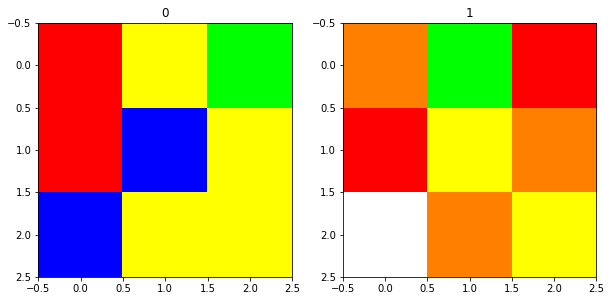

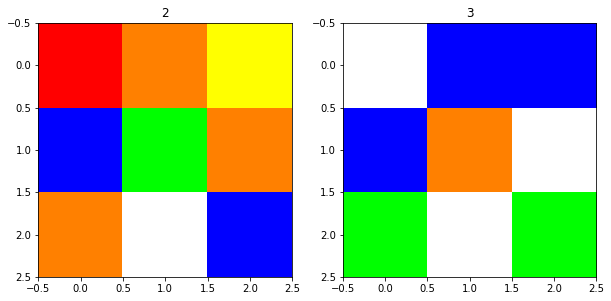

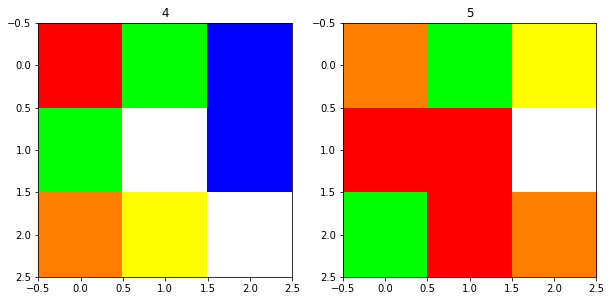

In [6]:
faceshow(cube)

In [7]:
imgshow(cube.stickers[0])
imgshow(cube.stickers[1])
imgshow(cube.stickers[2])
imgshow(cube.stickers[3])
imgshow(cube.stickers[4])
imgshow(cube.stickers[5])

In [8]:
len(cube.carray)    

54

In [9]:
imgshow(fin)

NameError: name 'fin' is not defined

In [ ]:
def cluster(img):
    img = img.reshape((img.shape[0]*img.shape[1],3))
    kmeans = KMeans(n_clusters=6)
    kmeans.fit(img)
    color_list = kmeans.cluster_centers_
    labels = kmeans.labels_
    return color_list,labels
                     

In [ ]:
def process(img,channel):
    temp = img.copy()
    img_area = temp.shape[0]*temp.shape[1]
    temp2 = cv2.GaussianBlur(temp.copy(),(17,17),0)
    #temp = temp-temp2
    #temp = cv2.GaussianBlur(temp,(7,7),0)

    if len(channel)!=1:
        temp = cv2.Canny(channel,25,50)
    else:
        temp = cv2.Canny(img,25,50)
    temp = cv2.GaussianBlur(temp,(5,5),0)
    temp = cv2.dilate(temp,np.ones([5,5]))
    contours,hierarchy = cv2.findContours(temp,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    rect_contours=[]
    areas = []        
    for cnt in contours:
        epsilon = 0.1*cv2.arcLength(cnt,True)
        approx = cv2.approxPolyDP(cnt,epsilon,True)
        if len(approx)==4:
            area = cv2.contourArea(cnt)
            rect_contours.append(cnt)
            areas.append(area)
    cube_area = areas[np.argmax(areas)]
    if cube_area < img_area/50 or cube_area>img_area/1.5:
        cube_area=img_area/3
    return areas,rect_contours,img_area,cube_area,contours

In [ ]:
img1 = face5.copy()
img = img1.copy()
areas,rect_contours,img_area,cube_area,contours = process(img,[0])
rect = []
for i in range(len(rect_contours)):
    if  areas[i]>cube_area/75 and areas[i]<cube_area/15:
        boxwidths = cv2.minAreaRect(rect_contours[i])
        rect.append(np.int0(cv2.boxPoints(boxwidths)))
n=5    
m=0
while(len(rect)!=9):
    n=5
    while(len(rect)!=9):
        rect = []    
        for i in range(len(rect_contours)):
            if  areas[i]>cube_area/(n*15) and areas[i]<cube_area/n:
                boxwidths = cv2.minAreaRect(rect_contours[i])
                rect.append(np.int0(cv2.boxPoints(boxwidths)))

        if n*100>cube_area:
            print("not converging",n)
            break
        n += 5
        if n==20:
            print("20 came")
    if m == 0:
            m += 1
    elif m == 1:
            img2 = img1.copy()
            img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(img2)
            areas,rect_contours,img_area,cube_area,contours = process(img2,v)
            m+=1
    elif m == 2:
            img2 = img1.copy()
            img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(img2)
            areas,rect_contours,img_area,cube_area,contours = process(img2,s)
            m+=1
    elif m == 3:
            img2 = img1.copy()
            img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(img2)
            areas,rect_contours,img_area,cube_area,contours = process(img2,h)
            m+=1
    elif m == 4:
            img2 = img1.copy()
            img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(img2)
            areas,rect_contours,img_area,cube_area,contours = process(img2,v)
            m+=1
    elif m == 5:
            img2 = img1.copy()
            img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(img2)
            areas,rect_contours,img_area,cube_area,contours = process(img2,s)
            m+=1
    elif m == 6:
            img2 = img1.copy()
            img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(img2)
            areas,rect_contours,img_area,cube_area,contours = process(img2,h)
            m+=1
    else:
        break  

#rect = contoursort(rect)
stickers = cv2.drawContours(img1.copy(),rect,-1,YELLOW,5)
imgshow(stickers)
print(len(rect_contours),len(areas),len(rect))
print(cube_area,img_area)

In [ ]:
rect = sorted(rect,key=lambda b:b[1][1],reverse=False)
rect[0:3] = sorted(rect[0:3],key=lambda b:b[1][0],reverse=False)
rect[3:6] = sorted(rect[3:6],key=lambda b:b[1][0],reverse=False)
rect[6:9] = sorted(rect[6:9],key=lambda b:b[1][0],reverse=False)
sq = np.asarray(rect).reshape(3,3,4,2)
tempimg = face0.copy()
for i in range(3):
    for j in range(3):
            x,y,w,h = cv2.boundingRect(sq[i][j])
            sec = tempimg[y:y+h,x:x+w]
            sec = cv2.resize(sec,(25,25))
            for y in range(sec.shape[0]):
                for x in range(sec.shape[1]):
                    for c in range(sec.shape[2]):
                        sec[y,x,c] = np.clip(1*sec[y,x,c] + 10, 0, 255)
            sec = cv2.GaussianBlur(sec,(21,21),0)
            imgshow(sec)

In [ ]:
print(len(cube.carray))
colours = cube.carray.copy()
colours=np.asarray(colours).reshape((9,6,3))